In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

# Data Analysis and Cleaning

In this notebook, we clean and analyse the data before applying machine learning algorithms on it.

TL;DR We aggregate the data by player, as we think knowing about individual dyads won't help us assess individual players' ski colour. Still, we keep the "racism" data associated with referees by aggregation and cross-featuring.

First, we need to load the data.

In [2]:
df = pd.read_csv('./data/CrowdstormingDataJuly1st.csv')
print(df.shape)
df.head(5)

(146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


As explained in the Data Description (see `Data.md` in the *data* folder), the data are in a format called referee-player dyads. In other terms, each row is a dyad between a player and a referee, *i.e.* interaction between a player and a referee. 

### Is `playerShort` a unique key ??

First of all, we need to understand the construction of the table.

As `playerShort` does not have a clear name defining it as a unique key for player, we want to ensure that it is the case. 

To do so, we will aggregate the `playerShort` with the birthday and check how many occurencies we have. If it is not a unique key, indeed, we will see a difference between number of `playerShort` and number of `playerShort`-`birthday`




In [3]:
print("number of unique playerShort: ", df['playerShort'].unique().shape[0])
print("number of unique playerShort and birthday: ", df.groupby(['playerShort', 'birthday']).size().count())

number of unique playerShort:  2053
number of unique playerShort and birthday:  2053


The `playerShort`field is, indeed, a unique ID for players.

We can see below that it deals with players having the same name by adding an extra number, which make `playerShort` a unique key.

In [4]:
df.loc[df["playerShort"].str.contains("abdoulaye-diallo")]['playerShort'].unique()

array(['abdoulaye-diallo_2', 'abdoulaye-diallo_3'], dtype=object)

## Clean the NaNs values for the colors of players

As we will work exclusively with skin_colour, the player who do not have this value are useless for our work.

Let's print the columns and the size:

In [5]:
print(df.columns)
print(df.shape)

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')
(146028, 28)


First, we can clean the skin color columns. To do so, we remove all the lines with NaN in *rater1* and *rater2* columns.

In [6]:
df = df.dropna(subset=['rater1', 'rater2'])
print(df.shape)
df.head(5)

(124621, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [7]:
# Check for other null values
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

There are some rows with null values in the *meanExp* and *meanIAT* columns:

## Create the skin_colour column

We define the skin_colour column as the mean of the *rater1* and *rater2* columns.

In [8]:
df['skin_colour'] = df[['rater1', 'rater2']].mean(axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


With this new valuea added, we can now remove the columns *rater1* and *rater2*.

In [9]:
df = df.drop(['rater1', 'rater2'], axis=1)
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


In [10]:
# Just check the unique values for the skin_colour column
unique_colours = df['skin_colour'].unique()
unique_colours

array([ 0.375,  0.75 ,  0.125,  1.   ,  0.25 ,  0.   ,  0.5  ,  0.875,
        0.625])

This means that we have the 5 values for the colour plus the values in-between.

## Remove useless columns (or impossible-to-aggregate columns)

Now, we want to remove some useless columns. 

In [11]:
print(df.columns)

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'refNum',
       'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp', 'skin_colour'],
      dtype='object')


We can remove the foloowing columns:
- *photoID*: We don't need it since we don't have the picture. =)
- *refNum*: We will aggregate the values with the name of the player.
- *refCountry*: We will aggregate the values with the name of the player.
- *Alpha_3*: We will aggregate the values with the name of the player.

We can also remove all the following columns since they concern only a specific referee:
- *meanIAT*
- *nIAT*
- *seIAT*
- *meanExp*
- *nExp*
- *seExp*

In [12]:
col_to_remove = ['photoID', 'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']
df_clean = df.drop(col_to_remove, axis=1)

In [13]:
print(df_clean.shape)
df_clean.head(5)

(124621, 17)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skin_colour
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,1.000


We now have 17 columns. We can now aggregate on the name of the players.

### Aggregation on `playerShort`

In order to aggregate value, we follow two different rules:
* **Keeping only one value** (the first): 
    * typically for values the we suppose to be unique for each player (height, birthday) 
    * or values too hard to be aggregated in other ways (club, ...)
* **Summing the values**: 
    * typically for integer values (victories, cards, ...)

In [14]:
# function that keeps only the first value
sole_value = lambda x : list(x)[0]

#dictionary that maps columns to aggregation functions
agg_funcs = {'player': sole_value, 'club' : sole_value, 'leagueCountry' : sole_value, 'birthday' : sole_value, \
             'height' : sole_value,'weight' : sole_value,'position' : sole_value, 'skin_colour': sole_value,\
            'games' : sum, 'victories' : sum, 'ties' : sum, \
            'defeats' : sum, 'goals' : sum, 'yellowCards' : sum, \
             'yellowReds' : sum, 'redCards' : sum}

#group and aggregate
df_players = df_clean.groupby('playerShort', as_index = True).agg(agg_funcs)
print("shape: ", df_players.shape)
df_players.head(3)

shape:  (1585, 16)


,goals,victories,leagueCountry,yellowCards,position,ties,redCards,yellowReds,defeats,height,birthday,player,games,weight,club,skin_colour
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,9,247,England,19,Center Back,179,0,0,228,182.0,08.11.1979,Aaron Hughes,654,71.0,Fulham FC,0.125
aaron-hunt,62,141,Germany,42,Attacking Midfielder,73,1,0,122,183.0,04.09.1986,Aaron Hunt,336,73.0,Werder Bremen,0.125
aaron-lennon,31,200,England,11,Right Midfielder,97,0,0,115,165.0,16.04.1987,Aaron Lennon,412,63.0,Tottenham Hotspur,0.250


Now, we can save this first DataFrame.

In [15]:
df_players.to_csv('./data/players.csv', index=False)

## Let's check the remaining NaN

What proportion of our data contains NaN values?

In [16]:
print("Percentage of people removed if we drop all na: ", 100*(1-df_players.dropna().shape[0]/df_players.shape[0]), "%%")

Percentage of people removed if we drop all na:  10.473186119873812 %%


Let's check the NA columns

In [17]:
df_players.isnull().any()

goals            False
victories        False
leagueCountry    False
yellowCards      False
position          True
ties             False
redCards         False
yellowReds       False
defeats          False
height            True
birthday         False
player           False
games            False
weight            True
club             False
skin_colour      False
dtype: bool

In [18]:
def replace_nan_by_mean(df, fields):
    for field in fields:
        df[field] = df[field].fillna((df[field].mean()), inplace = False)

# field height and weight can easily be replaced by a mean values of the other players
replace_nan_by_mean(df_players, ['height', 'weight'])

# field position in more complicated, we drop it
df_players_no_nan = df_players.dropna()

df_players_no_nan.isnull().any()

goals            False
victories        False
leagueCountry    False
yellowCards      False
position         False
ties             False
redCards         False
yellowReds       False
defeats          False
height           False
birthday         False
player           False
games            False
weight           False
club             False
skin_colour      False
dtype: bool

No more null values!

Therefore, we can save this new csv.

In [19]:
df_players_no_nan.to_csv('./data/players_no_nan.csv', index=False)

## Cross-Featuring

We can introduce some cross-features with the features we removed. We know for example that the columns with
- **IAT** refer to the **race IAT test**, *i.e.* a high value correspond to someone who will prefer a white person (thinks it's a better person) over a black person.
- **Exp** refer to the use of a **racial thermometer task**, *i.e.* a high value correspond to greater feelings of warmth toward whites versus blacks.

If we want to keep this information, we can use the cross these information with the yellow and red cards. 

Let's introduce a **new variable**. We will call it the `gravity_factor`. It is given by:


\begin{equation}
G = Y + \frac{\sum Y}{\sum YR}  YR + \frac{\sum Y }{\sum R} R
\end{equation}
where:
- $Y$ is the number of yellow cards given to a player
- $\sum Y$ is the total number of yellow cards given
- $YR$ is the number of yellow then red cards given to a player
- $\sum YR$ is the total number of yellow then red cards given
- $R$ is the number of red cards given to a player
- $\sum R$ is the total number of red cards given


So, let's add this new value to the big DF.

In [20]:
print("Percentage of yellow cards: ", 100*df['yellowCards'].sum()/
      df['games'].sum(), "%")
print("Percentage of yellow then red cards: ", 100*df['yellowReds'].sum()/
      df['games'].sum(), "%")
print("Percentage of red cards: ", 100*df['redCards'].sum()/
      df['games'].sum(), "%")

Percentage of yellow cards:  13.334065998868835 %
Percentage of yellow then red cards:  0.4028766950708586 %
Percentage of red cards:  0.4259288546025245 %


In [21]:
nbr_yellow = df['yellowCards'].sum()
nbr_yellowRed = df['yellowReds'].sum()
nbr_red = df['redCards'].sum()

In [22]:
gravity = df['yellowCards'] + nbr_yellow/nbr_yellowRed * df['yellowReds'] + nbr_yellow/nbr_red * df['redCards']
gravity.unique()

array([   0.        ,    1.        ,   31.30585274,   33.09713906,
         32.30585274,    2.        ,    4.        ,    3.        ,
         35.09713906,   34.09713906,   34.30585274,    5.        ,
         38.09713906,   36.09713906,   11.        ,   71.19427811,
          6.        ,    8.        ,   43.09713906,   33.30585274,
         42.09713906,   69.40299179,    7.        ,   35.30585274,
         37.09713906,   40.09713906,   39.09713906,  111.50013085,
         65.40299179,   66.19427811,   38.30585274,   67.40299179,
        101.29141717,   36.30585274,   62.61170548,   66.40299179,
         64.40299179,   64.61170548,   67.19427811,    9.        ,
         68.19427811,   69.19427811,   70.19427811,   74.40299179,
         70.40299179,   37.30585274,   10.        ,   68.61170548,
         71.40299179,  101.70884453,   41.09713906,   63.61170548,
         99.70884453,   40.30585274,   39.30585274,   99.29141717,
         73.40299179,   44.09713906,   66.61170548,   46.09713

In [23]:
df_with_features = df
df_with_features['gravity'] = gravity
df_with_features.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_colour,gravity
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0.0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,1.0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0.0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0.0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0.0


In [24]:
gravity_players = df_players['yellowCards'] + nbr_yellow/nbr_yellowRed * df_players['yellowReds'] + nbr_yellow/nbr_red * df_players['redCards']

In [25]:
df_players_with_features = df_players
df_players_with_features['gravity'] = gravity_players
df_players_with_features.head(3)

,goals,victories,leagueCountry,yellowCards,position,ties,redCards,yellowReds,defeats,height,birthday,player,games,weight,club,skin_colour,gravity
playerShort,,,,,,,,,,,,,,,,,
aaron-hughes,9,247,England,19,Center Back,179,0,0,228,182.0,08.11.1979,Aaron Hughes,654,71.0,Fulham FC,0.125,19.000000
aaron-hunt,62,141,Germany,42,Attacking Midfielder,73,1,0,122,183.0,04.09.1986,Aaron Hunt,336,73.0,Werder Bremen,0.125,73.305853
aaron-lennon,31,200,England,11,Right Midfielder,97,0,0,115,165.0,16.04.1987,Aaron Lennon,412,63.0,Tottenham Hotspur,0.250,11.000000


In [26]:
# Just check that the aggregation is correct
print("Gravity for 1st player in aggregated table: ", df_players_with_features['gravity'][0])
print("Gravity for 1st player in aggregated table: ", 
      df_with_features[df_with_features['player'] == 'Lucas Wilchez']['gravity'].sum())

# It's ok.. =)

Gravity for 1st player in aggregated table:  19.0
Gravity for 1st player in aggregated table:  116.70884453036449


We can now introduce another cross-features. The purpose this time is to use the *meanIAT* and *meanExp* values. To do so, we will link them with the 4 following features: *yellowCards*, *yellowReds*, *redCards*, and *gravity*. We will use the following equation:

\begin{equation}
F_{I-C} (P) = \frac{1}{\#R(P)} \sum_{r\in R(P)} \frac{C(r)}{E(r)} \cdot I(r)
\end{equation}

where:
- $F_{I-C} (P)$ defines the new feature.
- $I$ is the indicator. It can be *meanIAT* or *meanExp*
- $C$ defines the types of card received. It can be *yellowCards*, *yellowReds*, *redCards*, or *gravity*
- $P$ is a given player.
- $\#R(P)$ is the number of referees with whom a player played.
- $\sum_{r\in R(P)}$ is the sum over all referees who played with a given player.
- $C(r)$ is the value of $C$ for a specific Player and a specific referee.
- $E(r)$ is the number of times a referee played with a player.
- $I(r)$ is the indicator of the referee.

This will create 8 new features.

In [27]:
indicators = ['meanIAT', 'meanExp']
cards = ['yellowCards', 'yellowReds', 'redCards', 'gravity']

The aggregation process:

In [28]:
for idcts in indicators:
    for crds in cards:
        feature_name = idcts + "_" + crds
        array_feature = []
        print("Start feature ", feature_name)
        for plyr in df_players['player']:
            feature = 0
            # Get the DF with the player
            df_player = df[df['player'] == plyr]
            # Number of different referee
            nbr_ref = len(df_player)
            # Reindex
            df_player.index = np.arange(nbr_ref)
            # Sum for the new feature
            for i in range(nbr_ref):
                feature += df_player[crds][i]/df_player['games'][i]*df_player[idcts][i]
            # Add it into the array
            array_feature.append(feature/nbr_ref)
        # Add it into the DataFrame
        df_players_with_features[feature_name] = array_feature
df_players_with_features.head()

Start feature  meanIAT_yellowCards
Start feature  meanIAT_yellowReds
Start feature  meanIAT_redCards
Start feature  meanIAT_gravity
Start feature  meanExp_yellowCards
Start feature  meanExp_yellowReds
Start feature  meanExp_redCards
Start feature  meanExp_gravity


,goals,victories,leagueCountry,yellowCards,position,ties,redCards,yellowReds,defeats,height,birthday,player,games,weight,club,skin_colour,gravity,meanIAT_yellowCards,meanIAT_yellowReds,meanIAT_redCards,meanIAT_gravity,meanExp_yellowCards,meanExp_yellowReds,meanExp_redCards,meanExp_gravity
playerShort,,,,,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,9,247,England,19,Center Back,179,0,0,228,182.0,08.11.1979,Aaron Hughes,654,71.0,Fulham FC,0.125,19.000000,0.011768,0.000000,0.000000,0.011768,0.018965,0.000000,0.000000,0.018965
aaron-hunt,62,141,Germany,42,Attacking Midfielder,73,1,0,122,183.0,04.09.1986,Aaron Hunt,336,73.0,Werder Bremen,0.125,73.305853,0.035408,0.000000,0.000262,0.043596,0.049166,0.000000,0.000261,0.057339
aaron-lennon,31,200,England,11,Right Midfielder,97,0,0,115,165.0,16.04.1987,Aaron Lennon,412,63.0,Tottenham Hotspur,0.250,11.000000,0.006369,0.000000,0.000000,0.006369,0.011299,0.000000,0.000000,0.011299
aaron-ramsey,39,150,England,31,Center Midfielder,42,1,0,68,178.0,26.12.1990,Aaron Ramsey,260,76.0,Arsenal FC,0.000,62.305853,0.040849,0.000000,0.003218,0.141594,0.055985,0.000000,0.003232,0.157157
abdelhamid-el-kaoutari,1,41,France,8,Center Back,40,2,4,43,180.0,17.03.1990,Abdelhamid El-Kaoutari,124,73.0,Montpellier HSC,0.250,203.000262,0.020815,0.014147,0.003618,0.602321,0.020904,0.016674,0.003634,0.686509


After this work, we can save our various Data Frames to csv.

In [29]:
# Let's save the new DF
df_players_with_features.reset_index().to_csv('./data/players_with_features.csv', index=False)

In [30]:
# We can also save the one without the nan
df_players_with_features_no_nan = df_players_with_features.reset_index().dropna()
df_players_with_features_no_nan.to_csv('./data/players_with_features_no_nan.csv', index=False)

In [31]:
# We can remove all the columns with String values instead of numerical values.
non_numeric = ['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'position']
df_players_with_features.reset_index().drop(non_numeric, axis=1).to_csv('./data/players_with_features_only_num_values.csv', index=False)
df_players_with_features_no_nan.reset_index().drop(non_numeric, axis=1).to_csv('./data/players_with_features_no_nan_only_num_values.csv', index=False)

## Visualization of the data

Let's do some scatter plots to see if some features are interesting with the *skin_colour*. We expect that some features such as the number of games played will be irrelevant with the *skin_colour*.

In [32]:
features_tmp = df_players_with_features.columns
features = []
label = 'skin_colour'
for i in features_tmp:
    if i != 'skin_colour':
        features.append(i)

We plot *skin_colour* against all features, to get an idea of potential correlations.

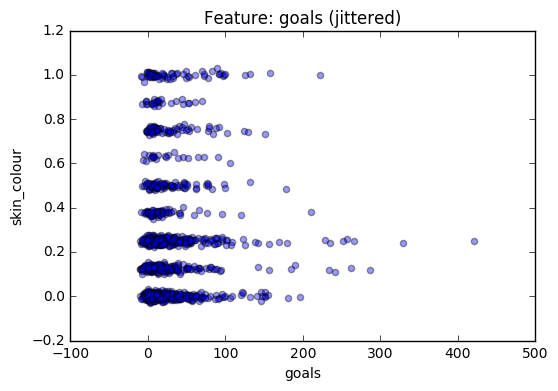

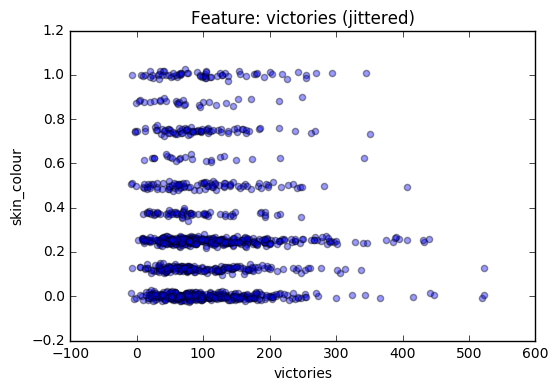

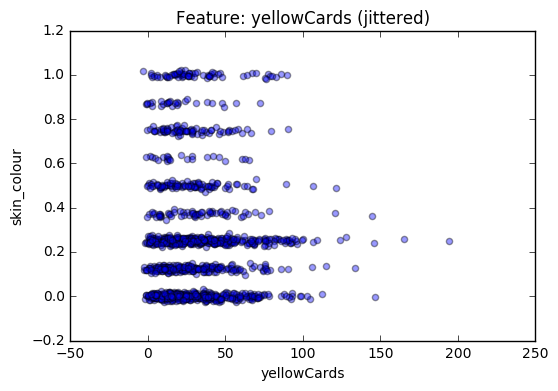

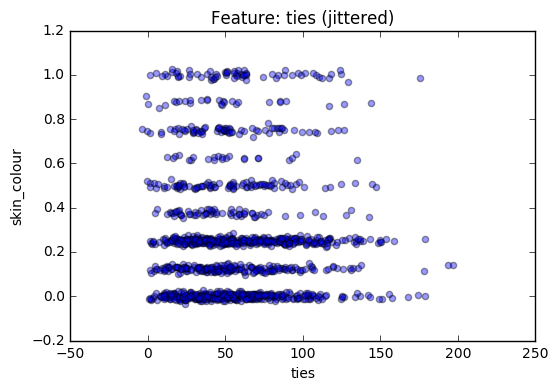

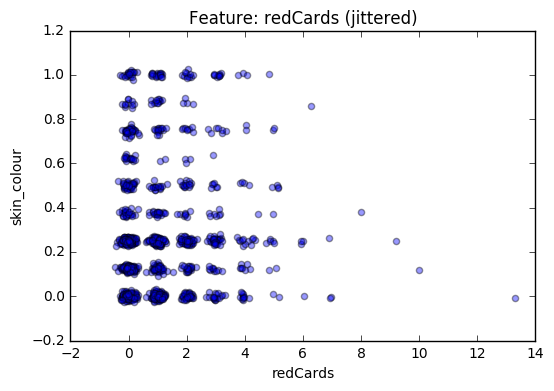

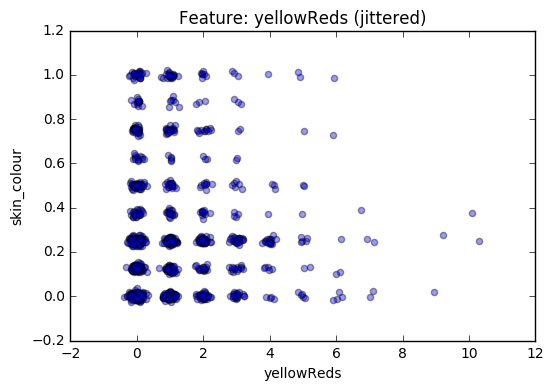

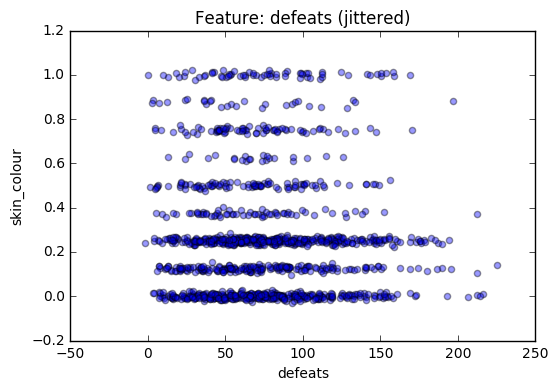

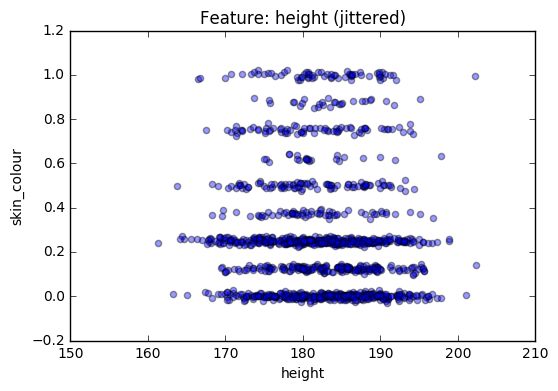

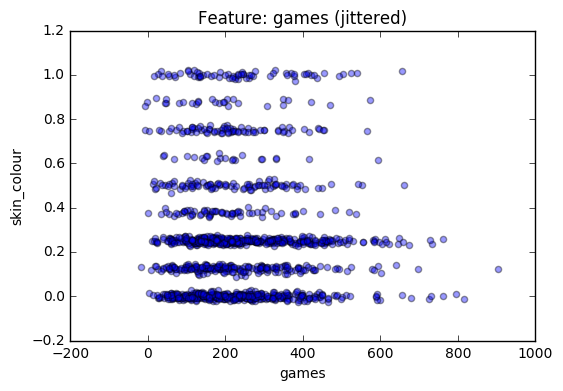

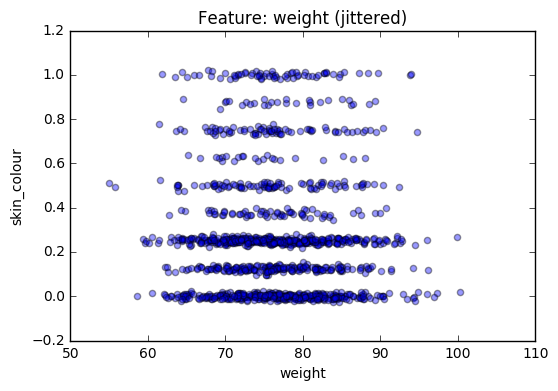

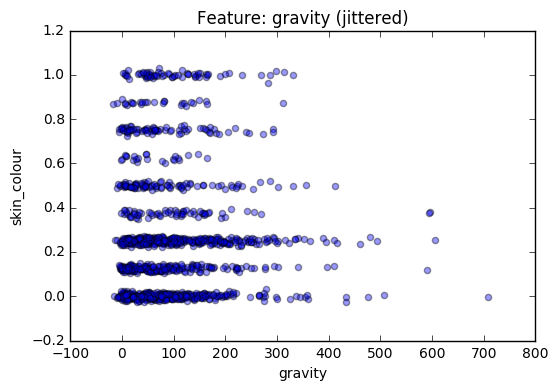

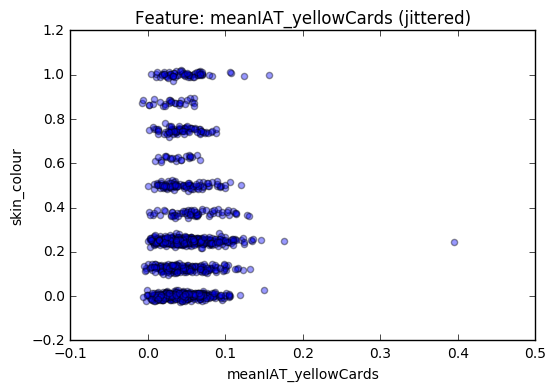

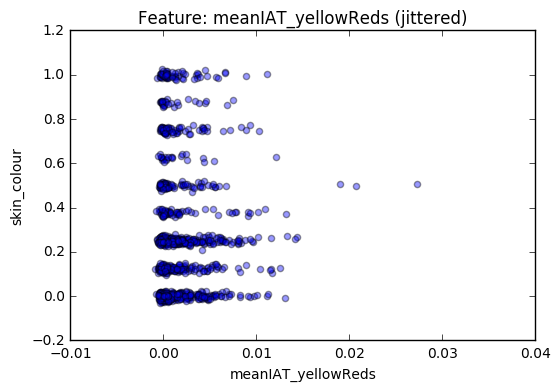

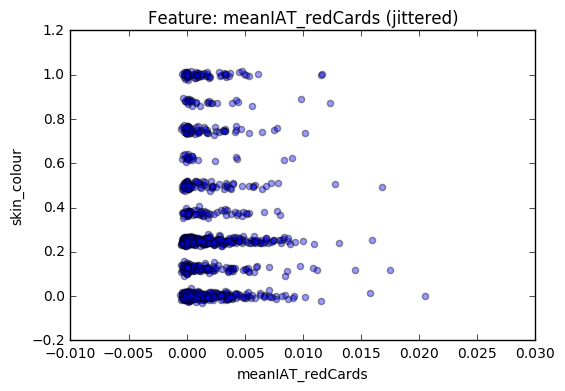

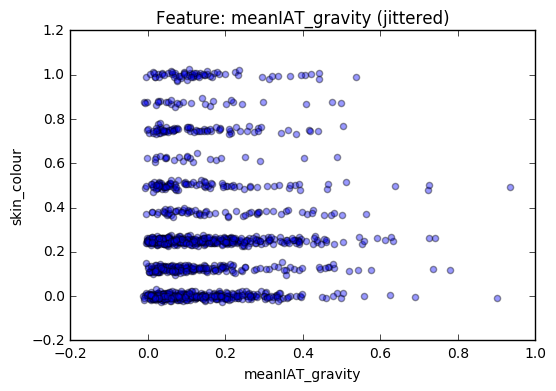

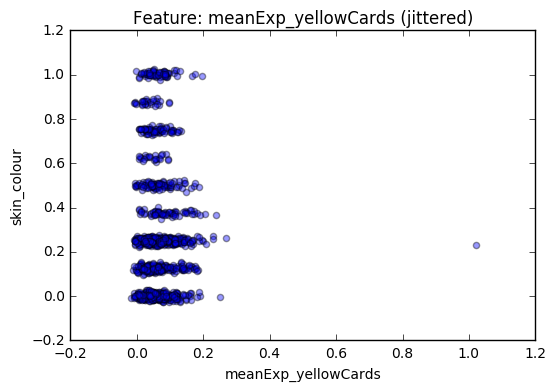

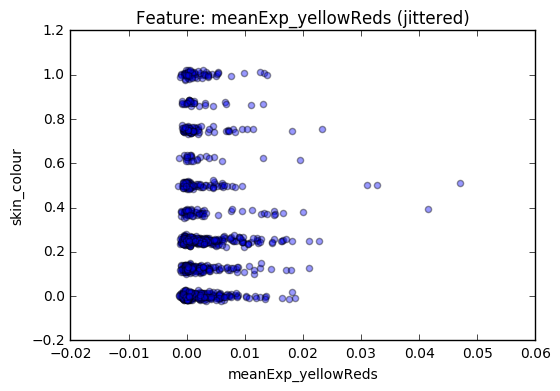

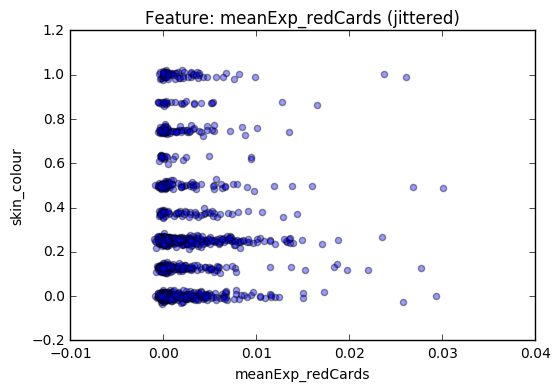

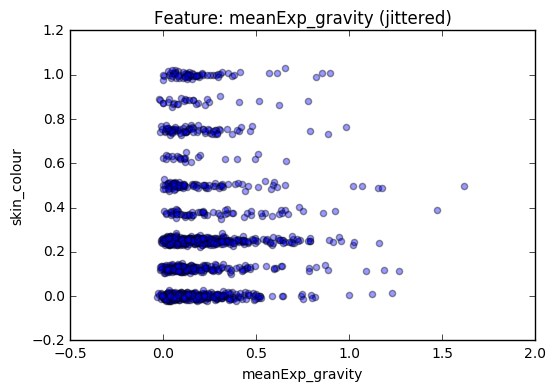

In [39]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=0.4, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

for ftre in features:
    if ftre not in non_numeric:
        plt.figure()
        jitter(list(df_players_with_features_no_nan[ftre]), list(df_players_with_features_no_nan[label]))
        plt.title('Feature: %s (jittered)'%(ftre))
        plt.xlabel(ftre)
        plt.ylabel(label)
        plt.show()

And it is now safe to say correlations might be hard to detect here ;)

See the next notebook for the machine learning part!